# The aim of this notebook is to create a model that predicts the size of a wildfire

Author: Marcelo Garcia Escalante

## Index

1. [EDA+Preprocess Data](#1.-EDA-(Exploratory-Data-Analysis)-+-preprocess-data)
 * [Clean data](#Clean-data)
     * [Parsing Dates](#Parsing-Dates)
     * [Find null values](#Find-null-values)
     * [fillining null data](#fillining-null-data)
 * [Feature engineering](#Feature-engineering)
 * [Standardize data](#Standardize-data)
 * [Visualize class distribution](#Visualize-class-distribution)
 
2. [Build Model](#2.-Build-Model)
 * [One Hot encode categorical data](#One-Hot-encode-categorical-data)
 * [Stratified cross validation](#Stratified-cross-validation)
 * [Define feature importance](#Define-feature-importance)
3. [Make submission](#3.-Make-submission)
4. [References](#4.-References)

In [1]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot, oneHotEnc_to_classes, parse_datetime_features_to_hours, RocCallback
from helpers import datetime_feature_engineering, fill_datetime_with_neighbors, fire_number_feature_engineering
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. EDA (Exploratory Data Analysis) + preprocess data

In this section, we will visualize and analyze our dataset. Also any possible clean-up required will be performed. 

In [898]:
# Loading the dataset
train = pd.read_csv('train_fuel2.csv')
test = pd.read_csv('test_fuel2.csv')

In [899]:
train.dtypes

fire_number                      object
fire_year                         int64
assessment_datetime              object
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
reported_date                    object
start_for_fire_date              object
fire_fighting_start_date         object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
bh_fs_date                       object
uc_fs_date                       object
ex_fs_date                       object


`note:` We can see that most of our data is categorical with two of the features being float numbers and one an integer

In [900]:
#Visualizing the train dataset
train.tail()

,fire_number,fire_year,assessment_datetime,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
15870,SWF001,2006,2006-04-07 17:55:00,B,55.355664,-115.776846,Indian Reservation,Incendiary,Lighting Fires,Arson Known,2006-04-07 16:46:00,UNP,LFS,2006-04-07 17:46:00,2006-04-07 17:46:00,2006-04-07 18:00:00,NaN,Fire Department,Surface,Flat,Clear,O1a,2006-04-07 17:55:00,2006-04-07 17:55:00,2006-04-07 19:30:00
15871,HWF091,2008,2008-06-03 15:35:00,A,58.743900,-117.223467,Provincial Land,Lightning,NaN,NaN,2008-06-02 19:00:00,UNP,UPA,2008-06-03 15:00:00,2008-06-03 15:03:00,2008-06-03 15:08:00,2008-06-03 16:00:00,HAC1F,Ground,Flat,Clear,C2,2008-06-03 16:42:00,2008-06-03 16:42:00,2008-06-03 18:24:00
15872,HWF234,2015,2015-06-26 15:27:00,E,59.846600,-116.768133,Provincial Land,Lightning,NaN,NaN,2015-06-26 12:00:00,UNP,UPA,NaN,2015-06-26 15:27:00,2015-06-26 17:30:00,2015-06-26 17:30:00,FTAC,Ground,Flat,CB Wet,C1,2015-06-26 22:00:00,2015-06-26 23:00:00,2015-07-01 10:46:00
15873,MWF097,2008,2008-07-19 14:59:00,A,56.300000,-112.535217,Provincial Land,Lightning,NaN,NaN,2008-07-19 13:48:00,LKT,GE,2008-07-19 14:48:00,2008-07-19 14:48:00,2008-07-19 14:55:00,2008-07-19 15:10:00,HAC1H,Surface,Flat,Cloudy,C2,2008-07-19 15:20:00,2008-07-19 15:30:00,2008-07-19 17:43:00
15874,SWF133,2015,2015-06-26 17:05:00,B,55.917023,-113.707167,Private Land,Resident,Debris Disposal,Unsafe Fire,2015-06-26 16:37:00,LKT,SQ,2015-06-26 16:42:00,2015-06-26 16:42:00,2015-06-26 16:51:00,2015-06-26 17:25:00,HAC,Surface,Flat,Clear,M2,2015-06-26 17:52:00,2015-06-26 19:35:00,2015-06-27 16:40:00


In [901]:
#Visualizing the test dataset
test.tail()

,fire_number,fire_year,assessment_datetime,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
3964,RWF047,2018,2018-07-30 17:21:00,52.490550,-115.964300,Provincial Land,Lightning,NaN,NaN,2018-07-30 16:30:00,AIR,HAC,2018-07-30 17:21:00,2018-07-30 17:21:00,2018-07-30 17:21:00,2018-07-30 17:42:00,HAC,Surface,Flat,Rainshowers,C3,2018-07-30 17:21:00,2018-07-30 17:50:00,2018-07-30 18:05:00
3965,GWF067,2009,2009-06-27 19:30:00,55.077350,-117.618717,Private Land,Resident,Refuse,Permit Related,2009-06-26 16:00:00,AIR,ASU,2009-06-27 17:54:00,2009-06-27 17:54:00,2009-06-27 19:00:00,NaN,Land Owner,Surface,Bottom,Cloudy,C2,2009-06-27 19:30:00,2009-06-27 19:30:00,2009-06-30 14:30:00
3966,GWF194,2006,2006-09-07 14:35:00,54.350328,-119.919998,Provincial Land,Restart,NaN,NaN,2006-09-01 16:00:00,AIR,MD,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-07 14:51:00,2006-09-07 15:35:00,HAC1F,Ground,Upper 1/3,Clear,C3,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-27 16:50:00
3967,LWF091,2012,2012-06-01 16:10:00,55.105667,-111.517000,Provincial Land,Recreation,Transportation,Vehicle Fire,2012-06-01 15:32:00,LKT,HL,2012-06-01 15:35:00,2012-06-01 15:35:00,2012-06-01 15:38:00,NaN,Fire Department,Surface,Bottom,Clear,O1a,2012-06-01 16:10:00,2012-06-01 16:10:00,2012-06-01 16:24:00
3968,GWF084,2008,2008-07-09 09:26:00,55.035717,-117.867233,Private Land,Resident,Unclassified,Unpredictable Event,2008-07-08 21:00:00,LKT,EC,2008-07-09 07:40:00,2008-07-09 07:40:00,2008-07-09 08:28:00,NaN,Fire Department,Surface,Flat,Clear,C2,2008-07-09 09:26:00,2008-07-09 09:26:00,2008-07-15 10:40:00


In [902]:
# Shape of dataset
print(f"The shape of train dataset is: {train.shape}")
print(f"The shape of test dataset is: {test.shape}")

The shape of train dataset is: (15875, 25)
The shape of test dataset is: (3969, 24)


`comment:` First thing we can notice is that the features are not the same. Train has 25 features while test has only 24. let's see what is the difference

In [903]:
train.columns[np.array([feature not in test.columns for feature in train.columns])][0]

'size_class'

That will mean that our testing dataset does not have labels. The reason for this is that this is a contest and the labels are not provided as this will be the metric to assess the performance of all the models proposed by each contestant. 

`size_class` is the target we want to predict with our model. Let's visualize what are the possible outcomes of this feature:


In [904]:
classes = list(train['size_class'].unique())
print(f"The possible classes in the target feature are: {classes}")

The possible classes in the target feature are: ['A', 'B', 'D', 'E', 'C']


That will mean that we have 5 classes to predict. In fact in the dataset information we can find that these classes represent ranges to which the wildfire grows until the final aree burned is determined after extinghishment. The area is catalogized as follows: 

* **A:** 0 to 0.1 [ha]
* **B:** 0.1 to 4 [ha]
* **C:** 4 to 40 [ha]
* **D:** 40 to 200 [ha]
* **E:** more than 200 [ha]

`note:` all sizes are in hectare(ha). $$ 1 ha = 10000 m^2 $$

### Clean data

In this section we will clean all unnecesary data or parse any data that it is required

#### Parsing Dates
 
 As shown from all information above, we can tell that columns that contain dates are presented in our dataset as strings. Therefore we will need to parse them back to dates. The features that should contain dates are:
 
 * `assessment_datetime` - The date and time the wildfire was originally assessed by Wildfire Management employees 
 * `fire_start_date` - The time and date the wildfire started.
 * `discovered_date` - The time the detection agent first discovered the wildfire.
 * `reported_date` - The time and date the wildfire was first reported to Wildfire Management
 * `start_for_fire_date` - The time and date that the first Wildfire Management resource started for the wildfire.
 * `fire_fighting_start_date` - The time and date that the initial action resource began physical suppression on the wildfire.
 * `bh_fs_date` - The date and time the Incident Commander (IC) determined the wildfire to be at the fire status of
being held (BH).
 * `uc_fs_date` - The date and time the Incident Commander determined the wildfire to be at the fire status of under
control (UC).
 * `ex_fs_date` - This is the date and time the Incident Commander determined the wildfire to be completely
extinguished (EX).


In [905]:
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
display(train[dates_list].sample(1))
train[dates_list].dtypes

,assessment_datetime,fire_start_date,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,bh_fs_date,uc_fs_date,ex_fs_date
5479,2006-09-07 14:40:00,2006-09-07 13:00:00,2006-09-07 13:40:00,2006-09-07 13:41:00,2006-09-07 13:53:00,2006-09-07 14:40:00,2006-09-07 15:20:00,2006-09-07 16:29:00,2006-09-08 13:10:00


assessment_datetime         object
fire_start_date             object
discovered_date             object
reported_date               object
start_for_fire_date         object
fire_fighting_start_date    object
bh_fs_date                  object
uc_fs_date                  object
ex_fs_date                  object
dtype: object

- We can see that all the dates have the format = `%y-%m-%d %H:%M:%S`
- We can also see that all of them have type object. Therefore we need to convert this values into datetime format

In [906]:
# parsing the object to datetime type
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [907]:
train[dates_list].dtypes

assessment_datetime         datetime64[ns]
fire_start_date             datetime64[ns]
discovered_date             datetime64[ns]
reported_date               datetime64[ns]
start_for_fire_date         datetime64[ns]
fire_fighting_start_date    datetime64[ns]
bh_fs_date                  datetime64[ns]
uc_fs_date                  datetime64[ns]
ex_fs_date                  datetime64[ns]
dtype: object

We can see that date features are now of type `datetime64`.

#### Find null values
we will look for empty or null values that could make invalid our analysis

In [908]:
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [909]:
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

`comment:` From above we can see that most of the missing data for both datasets are in the `true_cause` and `activity class` features, which means that we don't know what was the true reason of the wildfire or what was the activity that was going on when the wildfire was started. 

In [910]:
pd.set_option('display.max_columns', None)
print(f"Number of datapoints that have at least one value missing: {len(train[train.isnull().any(axis=1)])}")

Number of datapoints that have at least one value missing: 13052


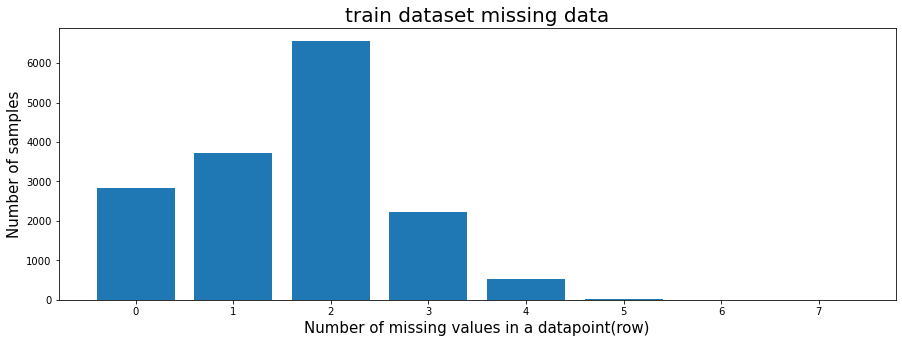

In [911]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(train.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('train dataset missing data', fontsize=20)
plt.show()

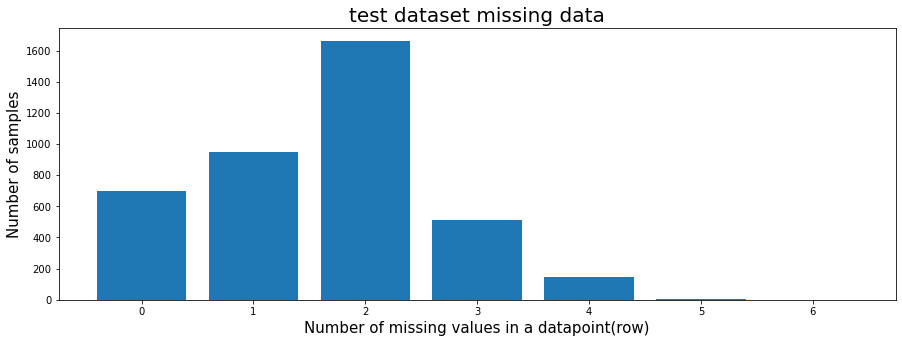

In [912]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(test.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('test dataset missing data', fontsize=20)
plt.show()

`comment:` We can see from above that in most of our data 2 missing features are common followed by one missing feature per row. Most likely `true_cause` and `activity class` as they are the most frequent missing feature. That means that perhaps it is not a good idea to trust in these features for building our model.

#### fillining null data
Since all of the features that contain null values are categorical, we will proceed to change the `NaN` to `unknown`

In [913]:
# First fill NAN datetime types with neighbor features
fill_datetime_with_neighbors(train)
fill_datetime_with_neighbors(test)

In [914]:
# Fill remaining object types
train = train.fillna('Unknown')
test = test.fillna('Unknown')

### Feature engineering

As we saw above we have many datetimes in out dataset. However, this will only be usable if we feed them to our model. To achieve this we will need to convert our datetime features to countable features. In this regard I will create new features for year month and day for all each datetime feature.

In [915]:
# feature engineering
train_feng = datetime_feature_engineering(train)
test_feng = datetime_feature_engineering(test)

In [916]:
# feature engineering fire_number
train_feng = fire_number_feature_engineering(train_feng)
test_feng = fire_number_feature_engineering(test_feng)

In [917]:
train_feng.dtypes

fire_number                      object
fire_year                         int64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
det_agent_type                   object
det_agent                        object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
fire_duration                   float64
time_to_ex                      float64
time_to_uc                      float64
time_to_bh2                     float64
time_to_bh                      float64
time_to_report                  float64
Location                         object
wildfires_in_location             int64
dtype: object

### Standardize data

It is important to standardize data as we don't want our model to skew towards features that have higher values

In [918]:
# lest visualize non-standard data first
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,wildfires_in_location
count,15875.000000,15875.000000,15875.000000,1.587500e+04,15875.000000,15875.000000,1.587500e+04,1.587500e+04,15875.000000,15875.000000
mean,2011.717228,54.984684,-115.258572,1.600204e+04,4615.530646,703.417134,-1.417583e+04,1.138651e+04,53.954583,96.932472
std,3.737510,2.669900,2.300677,4.716082e+05,23732.476442,4835.150244,7.250124e+05,4.709257e+05,2815.397723,73.564588
min,2006.000000,49.056267,-119.998067,0.000000e+00,0.000000,0.000000,-4.260241e+07,0.000000e+00,0.000000,1.000000
25%,2008.000000,53.066609,-116.824058,1.950000e+02,22.000000,0.000000,0.000000e+00,7.100000e+01,0.000000,39.000000
50%,2012.000000,55.336950,-115.156817,1.055000e+03,164.000000,0.000000,0.000000e+00,1.800000e+02,0.000000,81.000000
75%,2015.000000,56.876556,-114.340384,3.760000e+03,1573.000000,96.000000,2.300000e+01,8.950000e+02,2.000000,140.000000
max,2018.000000,59.999510,-110.000917,5.863460e+07,598146.000000,186751.000000,6.145600e+04,5.863078e+07,336614.000000,408.000000


In [919]:
# training standarized
numeric_features_indx = np.where(train_feng.dtypes!='O')[0]
numeric_features = train_feng.columns[numeric_features_indx]
standardize = RobustScaler()
train_feng[numeric_features] = standardize.fit_transform(train_feng[numeric_features])
# testing standarized
numeric_features_indx = np.where(test_feng.dtypes!='O')[0]
numeric_features = test_feng.columns[numeric_features_indx]
standardize = RobustScaler()
test_feng[numeric_features] = standardize.fit_transform(test_feng[numeric_features])


In [920]:
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,wildfires_in_location
count,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,1.587500e+04,15875.000000,15875.000000,15875.000000
mean,-0.040396,-0.092459,-0.040970,4.192719,2.870104,7.327262,-6.163404e+02,13.600138,26.977291,0.157747
std,0.533930,0.700771,0.926319,132.288413,15.301403,50.366148,3.152228e+04,571.511768,1407.698862,0.728362
min,-0.857143,-1.648496,-1.949228,-0.295933,-0.105738,0.000000,-1.852279e+06,-0.218447,0.000000,-0.792079
25%,-0.571429,-0.595898,-0.671280,-0.241234,-0.091554,0.000000,0.000000e+00,-0.132282,0.000000,-0.415842
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.428571,0.404102,0.328720,0.758766,0.908446,1.000000,1.000000e+00,0.867718,1.000000,0.584158
max,0.857143,1.223786,2.075916,16446.997195,385.546099,1945.322917,2.672000e+03,71153.640777,168307.000000,3.237624


In [921]:
test_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,wildfires_in_location
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3.969000e+03,3969.000000,3969.000000,3969.000000
mean,-0.044704,-0.082983,-0.032437,3.035042,2.290948,6.321836,-1.985643e+03,10.599685,9.170446,0.169098
std,0.535269,0.681130,0.951642,18.504762,9.587543,58.418068,6.668508e+04,84.132611,148.791520,0.743645
min,-0.857143,-1.525187,-2.017126,-0.279456,-0.108808,0.000000,-3.155700e+06,-0.224777,0.000000,-0.790000
25%,-0.571429,-0.589111,-0.675174,-0.227755,-0.093264,0.000000,0.000000e+00,-0.135377,0.000000,-0.410000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.428571,0.410889,0.324826,0.772245,0.906736,1.000000,1.000000e+00,0.864623,1.000000,0.590000
max,0.857143,1.188782,2.133778,572.299320,191.199482,3052.166667,1.481875e+03,2686.855683,7648.000000,3.250000



### Visualize class distribution
Lets visualize data distribution grouped by class of the target feature after the clean up

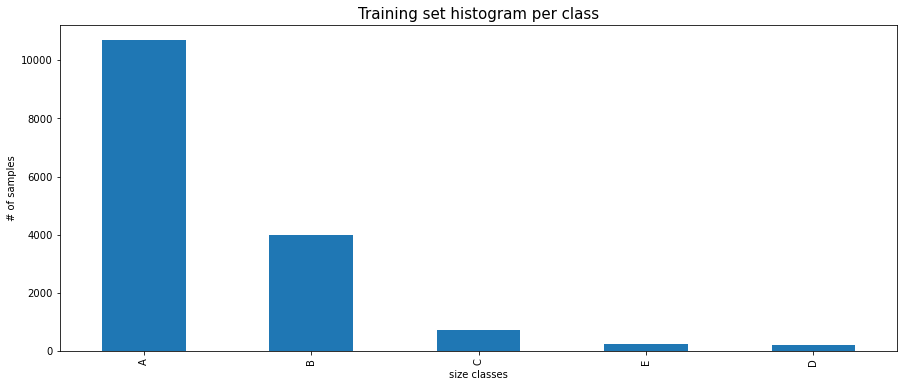

In [922]:
plt.figure(figsize=(15,6))
train_feng['size_class'].value_counts().plot(kind='bar');
plt.title('Training set histogram per class', fontsize=15);
plt.xlabel('size classes')
plt.ylabel('# of samples');

In [923]:
train_feng['size_class'].value_counts()

A    10679
B     4000
C      734
E      246
D      216
Name: size_class, dtype: int64

From plot above, we can notice that we have an unbalanced number of classes. Therefore, we must be very cautious to not make our model skew towards the classes with more data

In [766]:
from sklearn.utils import resample

# Separate majority and minority classes
df_A = train_feng[train_feng.size_class=='A']
df_B = train_feng[train_feng.size_class=='B']
df_C = train_feng[train_feng.size_class=='C']
df_D = train_feng[train_feng.size_class=='D']
df_E = train_feng[train_feng.size_class=='E']

print(len(df_A),len(df_B),len(df_C),len(df_D),len(df_E))


# Upsample minority class
df_B_upsampled = resample(df_B, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_C_upsampled = resample(df_C, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_D_upsampled = resample(df_D, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_E_upsampled = resample(df_E, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_A, df_B_upsampled, df_C_upsampled, df_D_upsampled, df_E_upsampled])
 
# Display new class counts
df_upsampled.size_class.value_counts()


10679 4000 734 216 246


D    10679
C    10679
E    10679
A    10679
B    10679
Name: size_class, dtype: int64

## 2. Build Model

In this section we will build a model to classify `size_class` of our dataset.


### One Hot encode categorical data

In [767]:
# Extract y_train and X_train
y_train = train_feng[['size_class']]
X_train = train_feng.drop(['size_class', 'fire_number'], 1)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
# Drop unknown features
Unknown_columns =[column for column in list(X_train_ohe.columns) if 'Unknown' in column]
X_train_ohe.drop(Unknown_columns, 1, inplace=True)
# Standardize categorical data
standardize = RobustScaler()
X_train_ohe[X_train_ohe.columns]=standardize.fit_transform(X_train_ohe)
#_, validation_X, _, validation_y = train_test_split(X_train_ohe, y_train, 
#                                                                test_size=0.35, random_state=2, 
#                                                                stratify=y_train)

In [924]:
# Extract y_train and X_train
y_train = train_feng[['size_class']]
X_train = train_feng.drop(['size_class', 'fire_number'], 1)
# Extract and X_test
X_test = test_feng.drop(['fire_number'], 1)

In [925]:
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

In [926]:
# Drop unknown features
#Unknown_columns =[column for column in list(X_test_ohe.columns) if 'Unknown' in column]
#X_test_ohe.drop(Unknown_columns, 1, inplace=True)
#X_train_ohe.drop(Unknown_columns, 1, inplace=True)

In [927]:
# Standardize categorical data
standardize = RobustScaler()
X_test_ohe[X_test_ohe.columns]=standardize.fit_transform(X_test_ohe)
standardize = RobustScaler()
X_train_ohe[X_train_ohe.columns]=standardize.fit_transform(X_train_ohe)

### Stratified cross validation

We are going to use stratified cross validation to mitigate the imbalance of the dataset that we saw in the EDA section [class distribution](#Visualize-class-distribution) 

In [928]:
train_X, validation_X, train_y, validation_y = train_test_split(X_train_ohe, y_train, 
                                                                test_size=0.3, random_state=2, 
                                                                stratify=y_train)

### Define feature importance

In all datasets there is always a high chance that some features are irrelevant to predict the target feature. We could try guessing which ones are the most relevant using our intuition. However, intuition is not always good. Therefore, there is an alternative way to do it using feature importances that is available for tree based models in Sklearn. To quickly identify some of the features let's use a simple random forest classifier.

In [210]:
#model = AdaBoostClassifier(random_state=42)
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

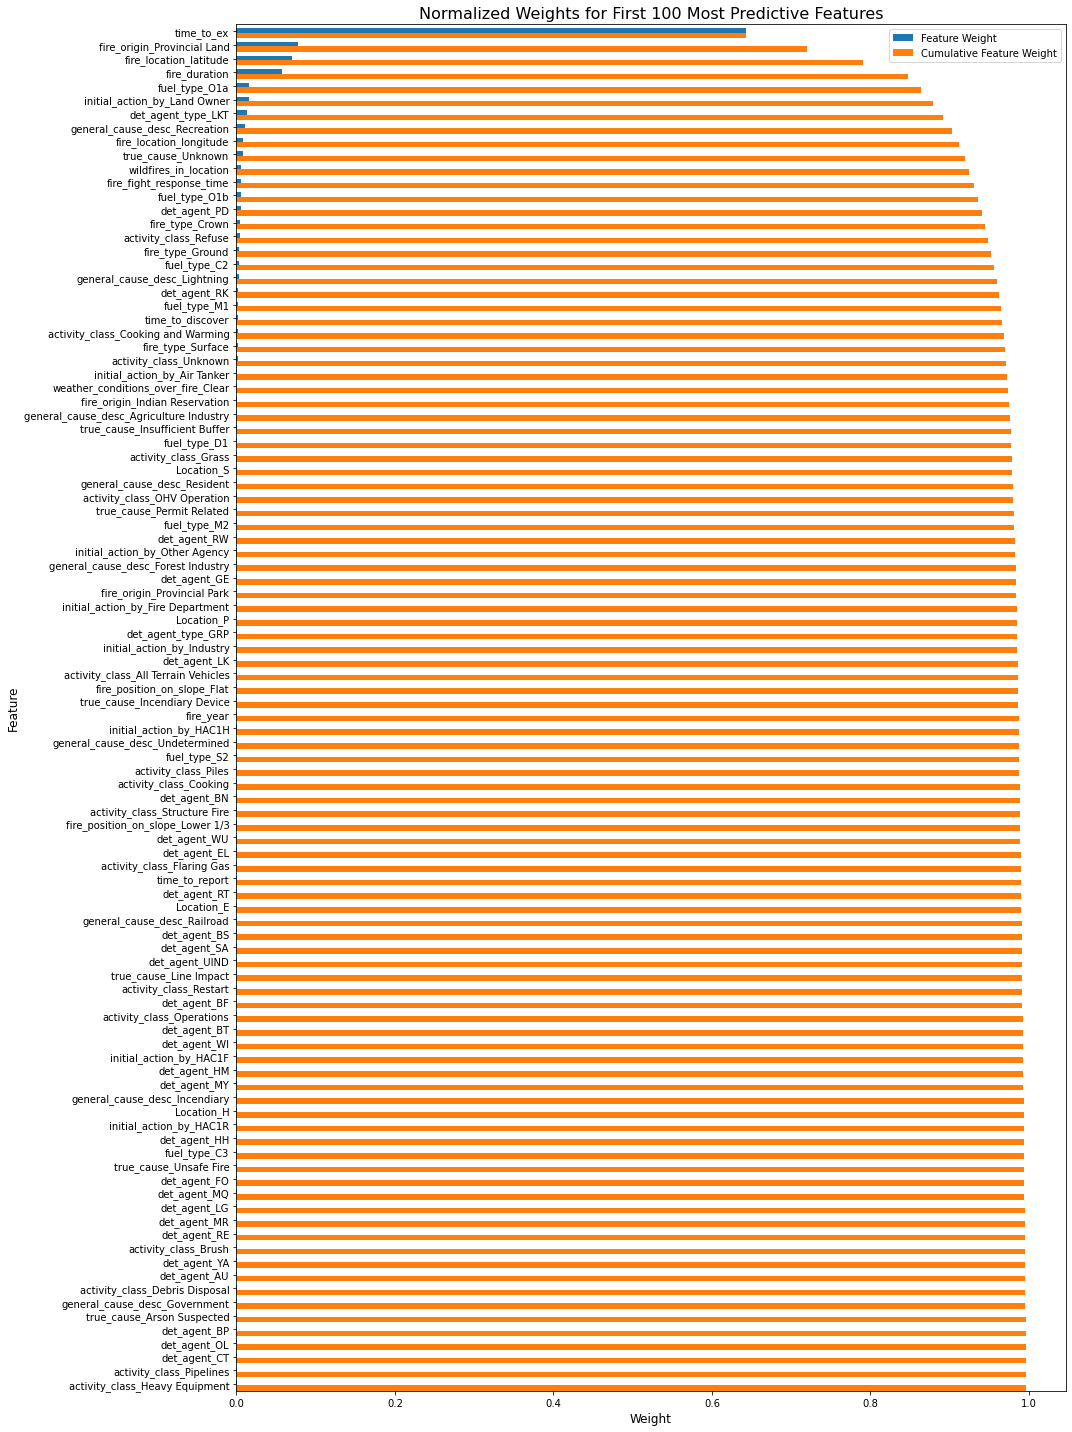

,Features,Importance value
0,time_to_ex,0.643082
1,fire_origin_Provincial Land,0.077189
2,fire_location_latitude,0.069815
3,fire_duration,0.057499
4,fuel_type_O1a,0.015698
...,...,...
95,det_agent_BP,0.000146
96,det_agent_OL,0.000139
97,det_agent_CT,0.000133
98,activity_class_Pipelines,0.000132


In [36]:
relevant_df = feature_plot(importances, train_X, train_y, top_k=100)
relevant_df

We are going to test the model by using only the first features that have more relevance than the remaining ones

In [219]:
most_relevant_features = relevant_df[relevant_df['Importance value']>=0.008]['Features']
most_relevant_features

0                     time_to_ex
1    fire_origin_Provincial Land
2         fire_location_latitude
3                  fire_duration
4                   fuel_type_S2
5             det_agent_type_LKT
6                  fuel_type_O1a
7        fire_location_longitude
Name: Features, dtype: object

## PCA

In [929]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca_train_X = pca.fit_transform(X_train_ohe)
pca_test_X = pca.transform(X_test_ohe)


In [930]:
pca_train_X.shape

(15875, 8)

In [931]:
pca_test_X.shape

(3969, 8)

#### PCA train and validation for splitted data

In [932]:
pca = PCA(n_components=8)
pca_train_split_X = pca.fit_transform(train_X)
pca_validation_split_X =  pca.transform(validation_X)
pca_test_X = pca.transform(X_test_ohe)

### Balanced models

In [1030]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from time import time
# define model
start = time()

#weights = {'A':1.5, 'B':4, 'C':15, 'D':30, 'E':30}
#weights = {'E': 13, 'D': 8.95240404040404, 'C': 3, 'B': 2, 'A': 1} #32.168 #33.779 #37325
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight=weights,
#                              criterion='entropy', max_features=None, min_impurity_decrease=0.003,
#                              n_jobs=-1) 
"""Best model so far"""
#weights = {'A':6, 'B':4, 'C':2.5, 'D':2, 'E':1}
#weights = {'A': 10, 'B': 8, 'C': 3, 'D': 2, 'E': 1} #31.455 test
weights = {'A': 13, 'B': 9, 'C': 3, 'D': 2, 'E': 1} # 32.041 test
weights = {'A': 13, 'B': 8.952631578947368, 'C': 3, 'D': 2, 'E': 1} #32.059
weights = {'A': 13, 'B': 8.952727272727273, 'C': 3, 'D': 2, 'E': 1} #32.162
weights = {'A': 13, 'B': 8.95240404040404, 'C': 3, 'D': 2, 'E': 1} #32.168 #33.779 #37.325
weights = {'A': 13.1717, 'B': 8.95240404040404, 'C': 3, 'D': 2, 'E': 1} #37.528
model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
                                       random_state=42, class_weight=weights,n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
""""""

#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=None), 
#                                n_estimators=10, random_state=42, sampling_strategy= 'all', n_jobs=-1)


#model = EasyEnsembleClassifier(base_estimator=RandomForestClassifier(n_estimators=100, max_depth=10, 
#                                                    class_weight='balanced_subsample', criterion='entropy', 
#                                                    max_features=None, min_impurity_decrease=0.003), 
#                               n_estimators=10, random_state=42, n_jobs=-1)


#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=300)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy'),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)

#weights = {'A': 13, 'B': 8.95240404040404, 'C': 4, 'D': 2.5, 'E': 2} #32.168 #33.779 #37325
#model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
#                                   max_depth=10, class_weight = weights, n_jobs = -1,
#                              criterion='entropy', max_features=None, min_impurity_decrease=0.03),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
metric = make_scorer(geometric_mean_score)
# evaluate model
scores = cross_val_score(model, pca_train_X, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, X_train_ohe[:], y_train, 
#                         scoring=metric, cv=cv, n_jobs=-1)

#scores = cross_val_score(model, X_train_ohe, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
end = time()
print(f'Mean f1-score: {np.mean(scores):.5f} time to CV model: {end-start} [s]')

Mean f1-score: 0.57094 time to CV model: 5.644829273223877 [s]


### Fine tune Hyper parameters

In [490]:
class_list = list(range(11,16))
class_list2 = np.linspace(8.8,9,100)
class_list3 = list(range(2,11))
list_of_weights = {'A':[13], 'B':class_list2, 'C':[3], 'D':[2], 'E':[1]}
best_score = 0.0
for A_value in list_of_weights['A']:
    for B_value in list_of_weights['B']:
        for C_value in list_of_weights['C']:
            for D_value in list_of_weights['D']:
                for E_value in list_of_weights['E']:
                    weights = {'A':A_value, 'B':B_value, 'C':C_value, 'D':D_value, 'E':E_value}
                    model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
                                       random_state=42, class_weight=weights, n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
                    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
                    scores = cross_val_score(model, pca_train_X, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
                    final_score = np.mean(scores)
                    print(f"Current score: {final_score}, Current weights: {weights}", end="\r", flush=True)
                    if final_score > best_score:
                        best_score = final_score
                        best_weighs = weights
                        print(f"Best score: {best_score}, Best weights: {best_weighs}\n")

'\nclass_list = list(range(11,16))\nclass_list2 = np.linspace(8.8,9,100)\nclass_list3 = list(range(2,11))\nlist_of_weights = {\'A\':[13], \'B\':class_list2, \'C\':[3], \'D\':[2], \'E\':[1]}\nbest_score = 0.0\nfor A_value in list_of_weights[\'A\']:\n    for B_value in list_of_weights[\'B\']:\n        for C_value in list_of_weights[\'C\']:\n            for D_value in list_of_weights[\'D\']:\n                for E_value in list_of_weights[\'E\']:\n                    weights = {\'A\':A_value, \'B\':B_value, \'C\':C_value, \'D\':D_value, \'E\':E_value}\n                    model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,\n                                       random_state=42, class_weight=weights, n_jobs = 1,\n                                      criterion=\'entropy\', max_features=None, min_impurity_decrease=0.003\n                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= \'all\')\n                    cv = RepeatedStratifiedKF

### Train Validation results

In [1031]:
model.fit(pca_train_split_X, train_y.values.ravel())
#model.fit(train_X[:], train_y.values.ravel())
#model.fit(X_train_ohe, y_train.values.ravel())

pred_validation_y = model.predict(pca_validation_split_X)
#pred_validation_y = model.predict(validation_X[:])
#pred_y = model.predict(X_train_ohe)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(pca_train_split_X)
#pred_train_y = model.predict(train_X[:])
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.5764727094872422
Geometric mean - validation:0.5834558709921841
Geometric mean per class - validation:[0.79735714 0.72848502 0.64299865 0.70605009 0.77011228]
-------------------------------------------------------------------------------------------
F1-score - train:0.6153169802631172
Geometric mean - train:0.6400723441143003
Geometric mean per class - train:[0.80024797 0.7292158  0.67001708 0.78260083 0.84104533]


In [403]:
# Extract the feature importances using .feature_importances_ 
#importances = model.feature_importances_
#relevant_df = feature_plot(importances, train_X, train_y, top_k=50)
#relevant_df

A    11346
B     3454
C      505
D      367
E      203
Name: size_class, dtype: int64

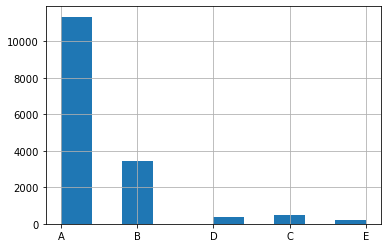

In [1038]:
y_valid_pred = pd.DataFrame()
y_valid_pred['fire_number'] = train_feng['fire_number']
#y_valid_pred['size_class'] = model.predict(X_train_ohe[:])
y_valid_pred['size_class'] = model.predict(pca_train_X)
y_valid_pred['size_class'].hist()
y_valid_pred['size_class'].value_counts()

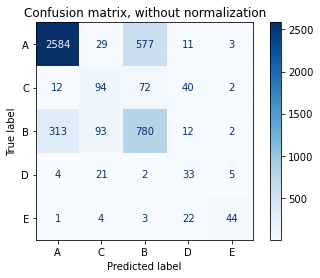

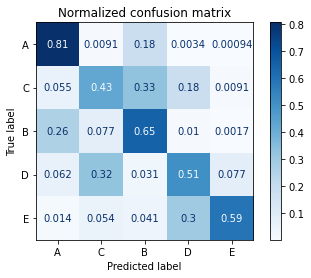

In [1032]:
from sklearn.metrics import plot_confusion_matrix

class_names = validation_y['size_class'].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, pca_validation_split_X, validation_y.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

### Deep Neural Network
[refence](https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/)

In [494]:
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adam

# define the neural network model
def define_NN_model(n_input):
    ## Hyperparameters
    lr = 1e-4
    dropout_prob = 0.5
    
    # define model
    
    model = Sequential(name='Wildfire model')
    model.add(Conv1D(filters=48, kernel_size=5, padding='same', activation='relu',
                         input_shape=(n_input, 1)))
    model.add(Flatten)
    model.add(Dense(10000, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout_prob))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    
    # define loss and optimizer
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
    return model

In [495]:
# One hot encode for the labels
ohe = ce.OneHotEncoder(use_cat_names=True)
y_train_ohe = ohe.fit_transform(train_y)
y_validation_ohe = ohe.transform(validation_y)

y_validation_ohe.sample(1)

,size_class_A,size_class_B,size_class_C,size_class_E,size_class_D
2108,1,0,0,0,0


In [496]:
#input_size = train_X[:].shape[1]
input_size = pca_train_split_X.shape[1]
model = define_NN_model(input_size)
model.summary()

TypeError: The added layer must be an instance of class Layer. Found: <class 'keras.layers.core.Flatten'>

In [459]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Callbacks definitions
early = EarlyStopping(monitor='val_loss', 
                       mode= 'min', 
                       patience=2)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=0, verbose=2, mode='min')

roc = RocCallback(training_data=(pca_train_split_X, y_train_ohe),
                  validation_data=(pca_validation_split_X, y_validation_ohe))

callbacks_list = [lr_reduce, early, roc]



## Run model {A, B, C, E, D}
#weights = {0:1, 1:2.7, 2:14.5, 3:43.5, 4:50}
weights = {0:1, 1:4.7, 2:14, 3:43, 4:50}
"""
model.fit(train_X[:], y_train_ohe, 
          validation_data=(validation_X[:], y_validation_ohe),
          epochs=100, verbose=1, class_weight=weights,
         callbacks=callbacks_list)
"""

model.fit(pca_train_split_X, y_train_ohe, 
          validation_data=(pca_validation_split_X, y_validation_ohe),
          epochs=100, verbose=1, class_weight=weights,
         callbacks=callbacks_list)


Train on 11906 samples, validate on 3969 samples
Epoch 1/100
11906/11906 [==============================] - 5s 431us/step - loss: 6.3026 - accuracy: 0.3067 - val_loss: 1.7661 - val_accuracy: 0.2585
roc-auc_train: 0.8005 - roc-auc_val: 0.7931                                                                                                    
Epoch 2/100
11906/11906 [==============================] - 5s 407us/step - loss: 5.5238 - accuracy: 0.4015 - val_loss: 1.2250 - val_accuracy: 0.2514
roc-auc_train: 0.8152 - roc-auc_val: 0.8031                                                                                                    
Epoch 3/100
11906/11906 [==============================] - 5s 404us/step - loss: 5.1676 - accuracy: 0.4455 - val_loss: 1.1849 - val_accuracy: 0.2590
roc-auc_train: 0.8161 - roc-auc_val: 0.8052                                                                                                    
Epoch 4/100
11906/11906 [==============================] - 5s 407us/step

roc-auc_train: 0.8232 - roc-auc_val: 0.8114                                                                                                    
Epoch 26/100
11906/11906 [==============================] - 5s 427us/step - loss: 4.4462 - accuracy: 0.5165 - val_loss: 1.0318 - val_accuracy: 0.3855

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
roc-auc_train: 0.8279 - roc-auc_val: 0.817                                                                                                    
Epoch 27/100
11906/11906 [==============================] - 5s 425us/step - loss: 4.4193 - accuracy: 0.5212 - val_loss: 1.0295 - val_accuracy: 0.3754

Epoch 00027: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
roc-auc_train: 0.8234 - roc-auc_val: 0.8108                                                                                                    
Epoch 28/100
11906/11906 [==============================] - 5s 424us/step - loss: 4.3764 - accuracy: 0.520

KeyboardInterrupt: 

In [ ]:
y_valid_pred = pd.DataFrame()
y_valid_pred['fire_number'] = df_upsampled['fire_number']
y_valid_pred['size_class'] = oneHotEnc_to_classes(model.predict(X_train_ohe[:]), 
                                                  y_validation_ohe.columns)
                                          
#y_valid_pred['size_class'] = model.predict(pca_train_X)
y_valid_pred['size_class'].hist()
y_valid_pred['size_class'].value_counts()

F1-score - validation:0.2823132515293403


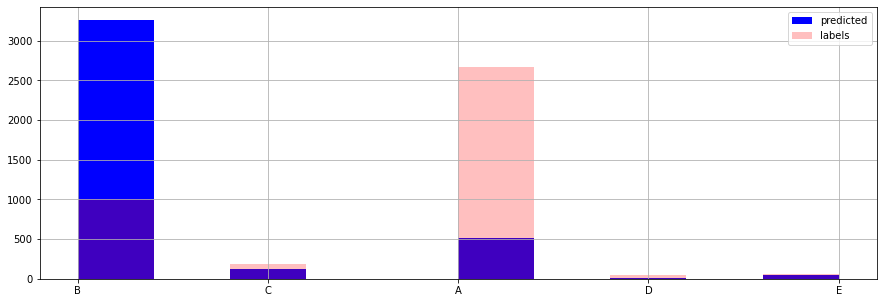

In [460]:
y_valid_pred = pd.DataFrame()
y_valid_pred['labels'] = validation_y.values.ravel()
y_valid_pred['size_class'] = oneHotEnc_to_classes(model.predict(pca_validation_split_X[:]), 
                                                  y_validation_ohe.columns)
                                          

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)    
#y_valid_pred['size_class'] = model.predict(pca_train_X)
y_valid_pred['size_class'].hist(ax=ax, color='b')
y_valid_pred['labels'].hist(ax=ax, alpha = 0.25,  color= 'r')
ax.legend(['predicted', 'labels'])

f1_score = fbeta_score(y_valid_pred['labels'], y_valid_pred['size_class'], beta = 1, average='macro')
print(f"F1-score - validation:{f1_score}")


Legitimate Transactions Detected (True Negatives):  0.968
Legitimate Transactions Incorrectly Detected (False Positives):  0.023
Fraudulent Transactions Missed (False Negatives):  0.9293478260869565
Fraudulent Transactions Detected (True Positives):  0.03260869565217391
Total Fraudulent Transactions:  1.0


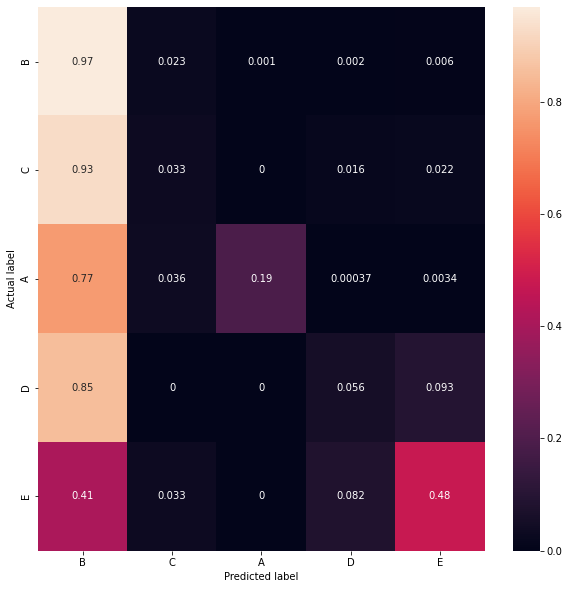

In [461]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions):
    class_names_pred = predictions.unique()
    class_names_labels = labels.unique()
    cm = confusion_matrix(labels, predictions, normalize='true', labels=class_names_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, xticklabels=class_names_pred, yticklabels=class_names_pred)#, fmt="d")
    #plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
plot_cm(y_valid_pred['labels'], y_valid_pred['size_class'])

#### Optimize model

In [544]:
# Initialize the classifier
model = GradientBoostingClassifier(random_state=42, max_depth=3)

# Create the parameters to tune
parameters = {  
    'n_estimators': [500],
    'learning_rate': [0.01]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_X[most_relevant_features].values, train_y.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions_validation = best_clf.predict(validation_X[most_relevant_features])
best_predictions_train = best_clf.predict(train_X[most_relevant_features])

# Report the before-and-afterscores
print("Optimized model\n------")
print("F-score on validation data: {:.4f}".format(fbeta_score(validation_y.values.ravel(), 
                                                              best_predictions_validation, 
                                                              beta = 1.0, average='macro')))

print("F-score on training data: {:.4f}".format(fbeta_score(train_y.values.ravel(), 
                                                            best_predictions_train, 
                                                            beta = 1.0, average='macro')))

Optimized model
------
F-score on validation data: 0.3184
F-score on training data: 0.4649


In [ ]:
# Initialize the classifier
model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
                                       random_state=42, n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(model, pca_train_X, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
final_score = np.mean(scores)

# Create the parameters to tune
parameters = {  
    'class_weight': [{'A':[1,3,4], 'B':7, 'C':7, 'D':2, 'E':1}]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_X[most_relevant_features].values, train_y.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions_validation = best_clf.predict(validation_X[most_relevant_features])
best_predictions_train = best_clf.predict(train_X[most_relevant_features])

# Report the before-and-afterscores
print("Optimized model\n------")
print("F-score on validation data: {:.4f}".format(fbeta_score(validation_y.values.ravel(), 
                                                              best_predictions_validation, 
                                                              beta = 1.0, average='macro')))

print("F-score on training data: {:.4f}".format(fbeta_score(train_y.values.ravel(), 
                                                            best_predictions_train, 
                                                            beta = 1.0, average='macro')))

In [545]:
best_clf

GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)

## 3. Make submission

In [1033]:
y_test_pred = pd.DataFrame()
y_test_pred['fire_number'] = test_feng['fire_number']
y_test_pred['size_class'] = model.predict(pca_test_X)
#y_test_pred['size_class'] = oneHotEnc_to_classes(model.predict(X_test_ohe[:]), 
#                                                 y_validation_ohe.columns)
#y_test_pred['size_class'] = model.predict(X_test_ohe[:])

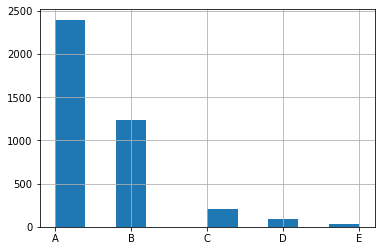

In [1034]:
y_test_pred['size_class'].hist()

In [1035]:
print(y_test_pred.shape)

(3969, 2)


### Push the prediction to CARINO platform

In [1036]:
import math
import requests

TOKEN = 'bef13dde60939ab809582f85a2518337f4eee028e2ea385cf64831961737072d977ed884b5c4e58821b1e5f1f5376aa2f6afecacab61ea9ecf406c89cc1e19cf' # Replace with 'your token' (please ensure value is between quotes)
comment = 'some comment' # Free text, visible by you only

def submit_prediction(df, TOKEN=None, sep=',', comment='', compression='gzip', **kwargs):
    if TOKEN is None:
        print("Please set TOKEN to the value provided in CARINO plarform under Submissions tab")
        return None
    URL='http://18.185.86.47/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} minutes.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0 / 60.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [1037]:
submit_prediction(y_test_pred, TOKEN, sep=',', index=True, comment=comment)

## 4. References

* [Stratified cross validation](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/)
* [Oversampling using SMOTE](https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8)

In [144]:
### Place holder
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 0 to 1195
Data columns (total 293 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   fire_year                                 float64
 1   fire_location_latitude                    float64
 2   fire_location_longitude                   float64
 3   fire_origin_Provincial Land               int64  
 4   fire_origin_Private Land                  int64  
 5   fire_origin_Indian Reservation            int64  
 6   fire_origin_DND                           int64  
 7   fire_origin_Metis Settlement              int64  
 8   fire_origin_Provincial Park               int64  
 9   fire_origin_Unknown                       int64  
 10  fire_origin_National Park                 int64  
 11  general_cause_desc_Lightning              int64  
 12  general_cause_desc_Incendiary             int64  
 13  general_cause_desc_Recreation             int64  
 14  general

In [145]:
X_test_ohe = ohe.transform(X_test)
X_test_ohe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3969 entries, 0 to 3968
Data columns (total 293 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   fire_year                                 float64
 1   fire_location_latitude                    float64
 2   fire_location_longitude                   float64
 3   fire_origin_Provincial Land               int64  
 4   fire_origin_Private Land                  int64  
 5   fire_origin_Indian Reservation            int64  
 6   fire_origin_DND                           int64  
 7   fire_origin_Metis Settlement              int64  
 8   fire_origin_Provincial Park               int64  
 9   fire_origin_Unknown                       int64  
 10  fire_origin_National Park                 int64  
 11  general_cause_desc_Lightning              int64  
 12  general_cause_desc_Incendiary             int64  
 13  general_cause_desc_Recreation             int64  
 14  general